In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import math

2025-02-18 00:13:47.500071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739837627.509743 1863165 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739837627.512669 1863165 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 00:13:47.523051: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Acoustic Array Geometry

In [3]:
geometry = pd.read_csv('../AA_geometry.tsv', header=None, sep='\t')
AA_Geometry = geometry.to_numpy().transpose()
#x = arrayGeometry[0]
#y = arrayGeometry[1]
#z = arrayGeometry[2]

# AA Geometry Top View

Text(0, 0.5, 'Y-axis')

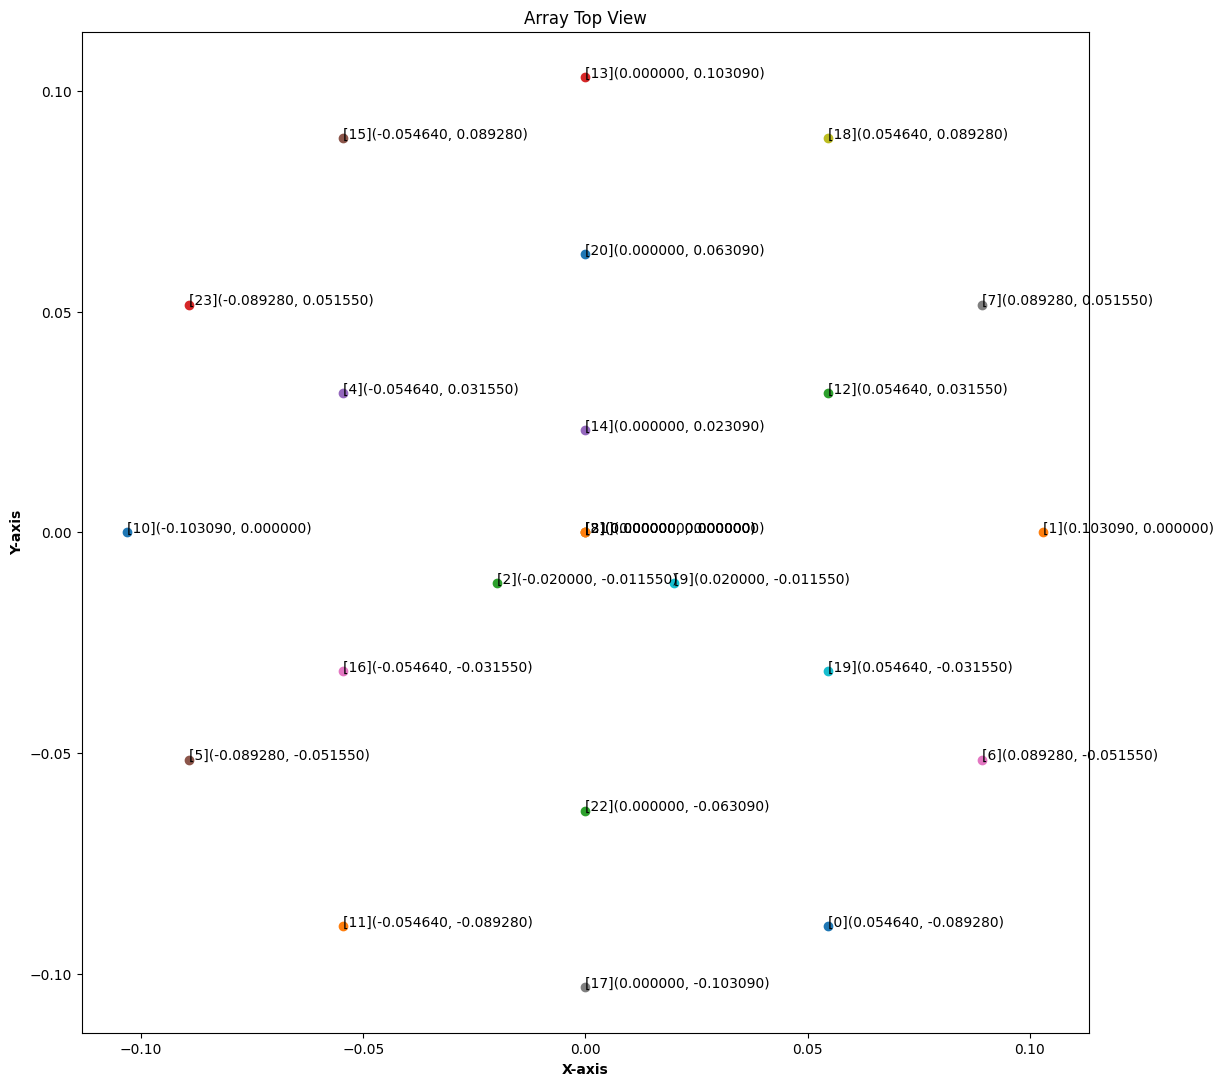

In [4]:
fig = plt.figure(figsize = (13,13))
ax = plt.axes()
for i in range(AA_Geometry.shape[1]):
    ax.scatter(AA_Geometry[0][i],AA_Geometry[1][i])
    ax.text(AA_Geometry[0][i], AA_Geometry[1][i], '[%s](%f, %f)'%(str(i), AA_Geometry[0][i], AA_Geometry[1][i]))
plt.title("Array Top View")
ax.set_xlabel('X-axis', fontweight ='bold') 
ax.set_ylabel('Y-axis', fontweight ='bold') 

# AA Geometry 3D View

Text(0.5, 0, 'Z-axis')

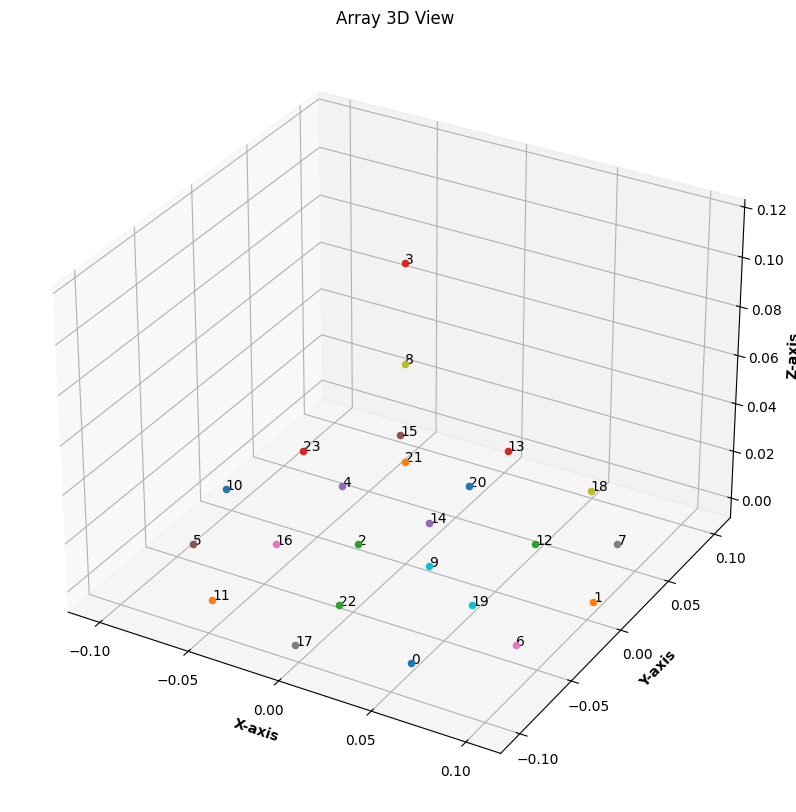

In [5]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection = "3d")
for i in range(AA_Geometry.shape[1]):
    ax.scatter(AA_Geometry[0][i],AA_Geometry[1][i],AA_Geometry[2][i])
    ax.text(AA_Geometry[0][i],AA_Geometry[1][i],AA_Geometry[2][i], '%s'%(str(i)))
plt.title("Array 3D View")
ax.set_xlabel('X-axis', fontweight ='bold') 
ax.set_ylabel('Y-axis', fontweight ='bold') 
ax.set_zlabel('Z-axis', fontweight ='bold')

# Extract Data

In [6]:
def key(x):
    return(x[26])

In [7]:
path_dir = "../data/rss45/"
n_channels = 24

In [38]:
# Time delay files
files_tau = [i for i in os.listdir(path_dir) if os.path.isfile(os.path.join(path_dir,i)) and \
         'tau.bin' in i]
files_tau = sorted(files_tau, key = key)   
print(files_tau)

['random_signal_source_info_0_tau.bin', 'random_signal_source_info_1_tau.bin', 'random_signal_source_info_2_tau.bin', 'random_signal_source_info_3_tau.bin', 'random_signal_source_info_4_tau.bin']


In [9]:
# Extract Time delay
taus = []
for file in files_tau:
    with open(path_dir+file, 'rb') as f:
        delay = f.read()
        delay = np.frombuffer(delay, dtype = np.float32)
        delay = np.resize(delay, (int(len(delay)/n_channels), n_channels))
        taus.append(delay)
taus_np = np.array(taus)
taus_np = taus_np.reshape(taus_np.shape[0]*taus_np.shape[1], taus_np.shape[2])

In [10]:
# Source signal information files
files_dat = [i for i in os.listdir(path_dir) if os.path.isfile(os.path.join(path_dir,i)) and \
         '.dat' in i]
files_dat = sorted(files_dat, key = key)   
files_dat

['random_signal_source_info_0.dat',
 'random_signal_source_info_1.dat',
 'random_signal_source_info_2.dat',
 'random_signal_source_info_3.dat',
 'random_signal_source_info_4.dat']

In [11]:
# Extract signal information
dats = []
for file in files_dat:
    with open(path_dir+file, 'r') as f:
        lines = f.readlines()
        for i,l in enumerate(lines):
            if (i>0):
                dat = [float(i) for i in l.split()]
                dats.append(dat)
dats_np = np.array(dats)
dats_np

array([[4.80e+04, 3.43e+02, 1.72e+01, 0.00e+00],
       [4.80e+04, 3.43e+02, 4.25e+01, 0.00e+00],
       [4.80e+04, 3.43e+02, 1.56e+01, 0.00e+00],
       ...,
       [4.80e+04, 3.43e+02, 2.06e+01, 0.00e+00],
       [4.80e+04, 3.43e+02, 3.80e+00, 0.00e+00],
       [4.80e+04, 3.43e+02, 2.50e+00, 0.00e+00]])

In [12]:
# Input/Output data
X_data = taus_np
Y_data = dats_np[:,2]

Text(0, 0.5, 'Y-axis')

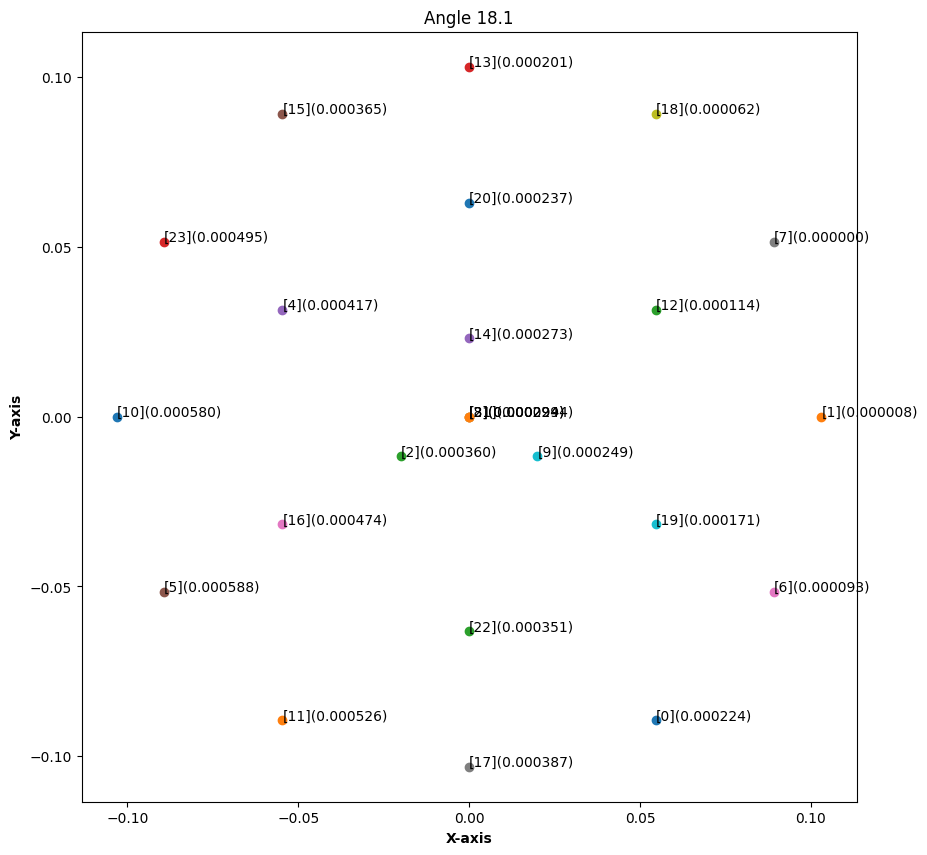

In [13]:
# Test
fig = plt.figure(figsize = (10,10))
ax = plt.axes()
angle_id = 8
for i in range(AA_Geometry.shape[1]):
    ax.scatter(AA_Geometry[0][i],AA_Geometry[1][i])
    ax.text(AA_Geometry[0][i],AA_Geometry[1][i], '[%s](%f)'%(str(i), X_data[angle_id,i]))
plt.title("Angle %s"%(str(Y_data[angle_id])))
ax.set_xlabel('X-axis', fontweight ='bold') 
ax.set_ylabel('Y-axis', fontweight ='bold') 

In [14]:
# Estimating the data correctness
for i in range(n_channels):
    t = math.sqrt((AA_Geometry[0][7] - AA_Geometry[0][i])**2 + (AA_Geometry[1][7]-AA_Geometry[1][i])**2) / 343
    print( '[%s] '%(str(i)), t, X_data[1,i])
    print("Diff: ", t-X_data[1,i])

[0]  0.0004228211293417438 0.0003518445
Diff:  7.097662e-05
[1]  0.0001555911586754117 7.1850955e-05
Diff:  8.3740204e-05
[2]  0.0003678987063499147 0.00035918195
Diff:  8.716743e-06
[3]  0.00030056486330339515 0.00029344257
Diff:  7.1222894e-06
[4]  0.0004236239527639102 0.00034874858
Diff:  7.487537e-05
[5]  0.0006011297266067903 0.00058688514
Diff:  1.4244579e-05
[6]  0.00030058309037900874 0.00020307102
Diff:  9.7512064e-05
[7]  0.0 0.0
Diff:  0.0
[8]  0.00030056486330339515 0.00029344257
Diff:  7.1222894e-06
[9]  0.0002732033305781843 0.0002732021
Diff:  1.2223609e-09
[10]  0.0005806334490615953 0.0005150342
Diff:  6.559928e-05
[11]  0.0005870568827290685 0.0005867415
Diff:  3.153691e-07
[12]  0.00011661551017585942 0.00011385158
Diff:  2.7639326e-06
[13]  0.0003005502862204093 9.039126e-05
Diff:  0.00021015902
[14]  0.00027319651077657866 0.00024796333
Diff:  2.5233196e-05
[15]  0.00043377103344321413 0.00023504064
Diff:  0.00019873038
[16]  0.00048451421646693885 0.00047303358
D

Text(0, 0.5, 'Time Delay (ms)')

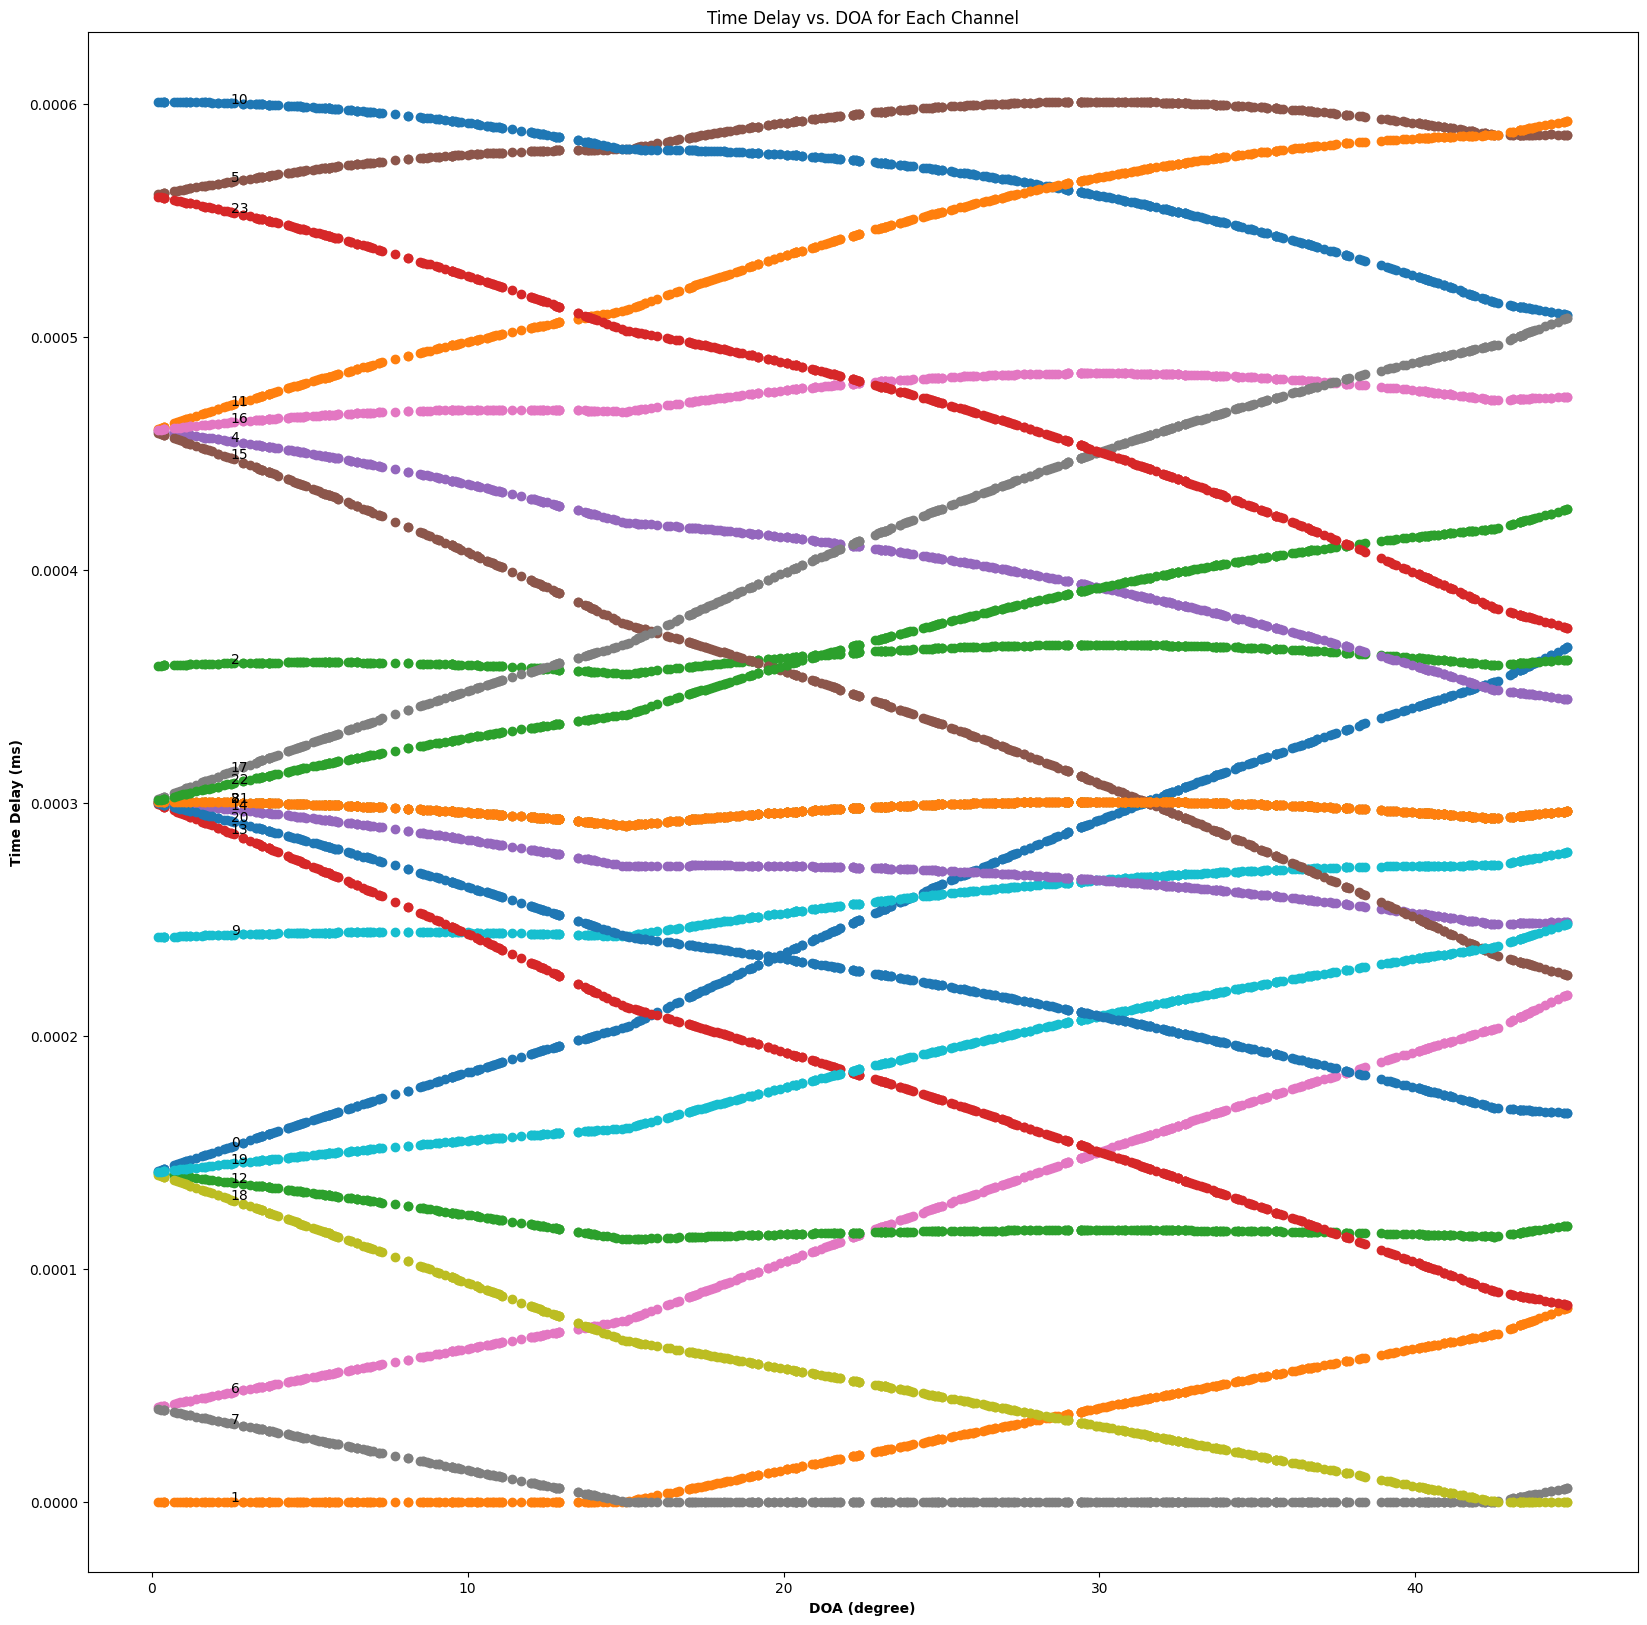

In [15]:
# Time delay vs angle at different channel
fig = plt.figure(figsize = (20,20))
ax = plt.axes()
for i in range(n_channels):
    ax.scatter(Y_data, X_data[:,i])
    ax.text(Y_data[-1], X_data[-1,i], '%s'%(str(i)))
plt.title("Time Delay vs. DOA for Each Channel")
ax.set_xlabel('DOA (degree)', fontweight ='bold') 
ax.set_ylabel('Time Delay (ms)', fontweight ='bold') 

In [19]:
# Train/Test spilt
indices = np.random.permutation(X_data.shape[0])
train_id, test_id = indices[:int(X_data.shape[0]*0.80)], indices[int(X_data.shape[0]*0.80):]
x_train, y_train, x_test, y_test = X_data[train_id,:], Y_data[train_id], X_data[test_id,:], Y_data[test_id]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((400, 24), (400,), (100, 24), (100,))

In [20]:
# Pre scaling the Input
max_norm = np.max(np.max(x_train))
#pre_scale = 10000
x_train /= max_norm
x_test /= max_norm

# Experiment with 1 Channel

In [378]:
# Train/Test with 1 channel
channel_id = 1 
x_train_1 = x_train[:, [channel_id]]
y_train_1 = y_train
x_test_1 = x_test[:, [channel_id]]
y_test_1 = y_test

x_train_1.shape

(400, 1)

In [379]:
# Train/Test with angle range between 15-45 degree
x_train_tmp = []
y_train_tmp = []
for i in range(len(x_train_1)):
    if (y_train_1[i] > 15.0):
        x_train_tmp.append(x_train_1[i])
        y_train_tmp.append(y_train_1[i])
x_train_1 = np.array(x_train_tmp)
y_train_1 = np.array(y_train_tmp)

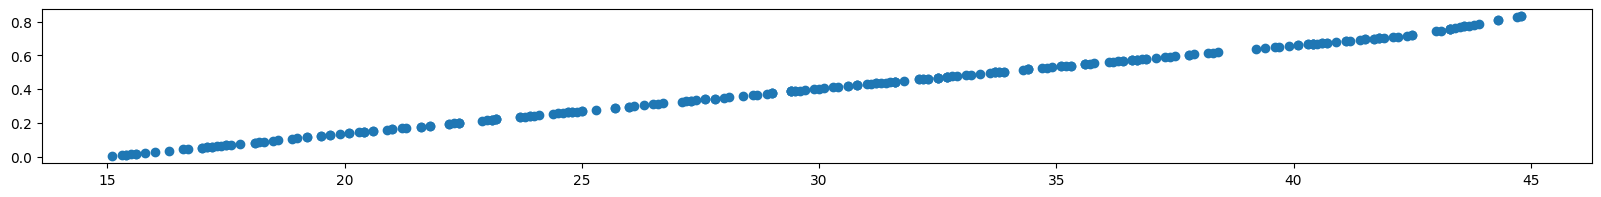

In [314]:
fig = plt.figure(figsize = (20,2))
ax = plt.axes()
ax.scatter(y_train_1, x_train_1)

In [359]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Input(x_train_1[0].shape),
    #tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1, activation = 'linear')
])
model1.summary()

Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_197 (Dense)               │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609 (2.38 KB)

 Trainable params: 609 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

In [360]:
model1.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [362]:
losses = model1.fit(x_train_1, y_train_1,
                   batch_size=4,
                   epochs=100)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.0474 - mae: 0.1325
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 0.0516 - mae: 0.1428
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.0627 - mae: 0.1593
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 0.0907 - mae: 0.1811
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 0.0390 - mae: 0.1296
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 0.0467 - mae: 0.1394
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.0363 - mae: 0.1371
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.0478 - mae: 0.1455
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0631 - mae: 0.1450  
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0489 - mae: 0.1357  
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0566 - mae: 0.1450  
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0653 - mae: 0.1433  
Epoch 13/100


In [340]:
model1.predict(x_test_1), y_test_1

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


(array([[14.789262],
        [32.876102],
        [31.315039],
        [26.359285],
        [38.87425 ],
        [18.568708],
        [33.167255],
        [28.85055 ],
        [24.853662],
        [39.616573],
        [14.789262],
        [45.888737],
        [41.541782],
        [21.416962],
        [38.68793 ],
        [14.789262],
        [31.902016],
        [14.789262],
        [33.5547  ],
        [35.382183],
        [40.354065],
        [25.757925],
        [14.789262],
        [26.959375],
        [21.518436],
        [14.789262],
        [21.61989 ],
        [25.557196],
        [24.853662],
        [26.859446],
        [42.89016 ],
        [44.76698 ],
        [30.135721],
        [28.453627],
        [14.789262],
        [26.659496],
        [14.789262],
        [18.874434],
        [19.99439 ],
        [21.315477],
        [14.789262],
        [31.217022],
        [41.94849 ],
        [17.75297 ],
        [39.709026],
        [25.85824 ],
        [41.7233  ],
        [22.1

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


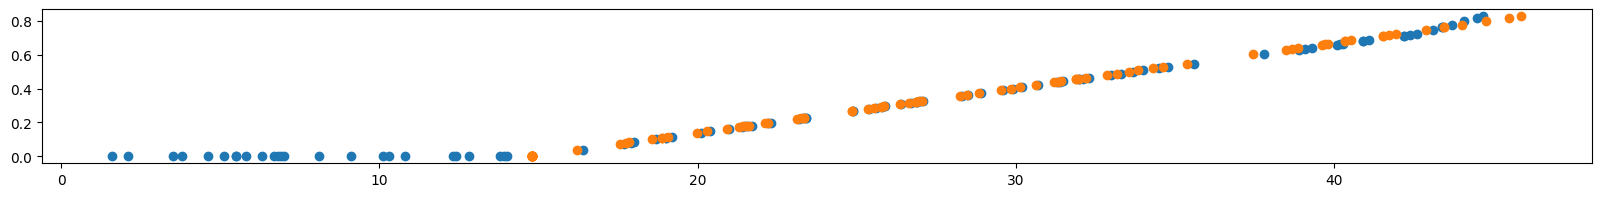

In [342]:
fig = plt.figure(figsize = (20,2))
ax = plt.axes()
ax.scatter(y_test_1, x_test_1)
ax.scatter(model1.predict(x_test_1), x_test_1)

# Experiment with 1 channels
#### For 1 channel, the range of degree must be non zero or the solution must be unique.
#### The input needs scaling because tau is too small. Currently, scale by 10k give good result.
#### MLP with 2 or more hidden layers have about the same loss.
#### A model with 2 hidden layers size of 32 and 16 and small batch size of 4 converage around 20 to 30 epochs
#### The relu activation outpreform sigmoid activation.
#### Larger batch size seem to preform worse.
#### From the actual and predicted curve, they are similar except for the elbow at around 43 degree.


# Experiment with 2 Channels

In [382]:
# Train/Test with 2 channel
channel_id = [1,7] 
x_train_2 = x_train[:, channel_id]
y_train_2 = y_train
x_test_2 = x_test[:, channel_id]
y_test_2 = y_test

x_train_2.shape

(400, 2)

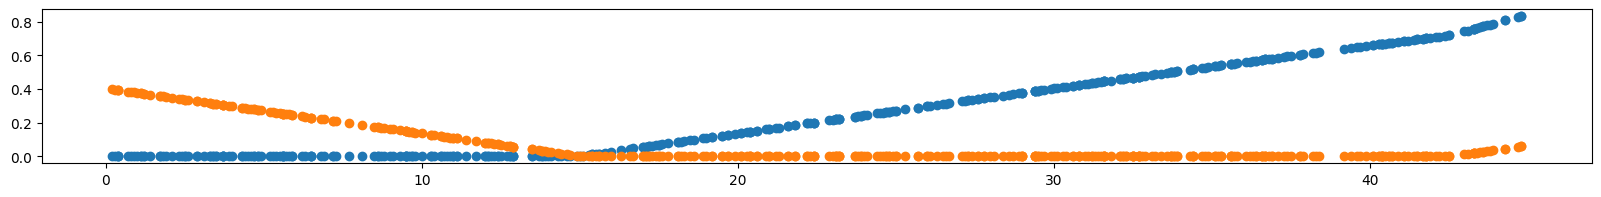

In [373]:
fig = plt.figure(figsize = (20,2))
ax = plt.axes()
for i in range(len(channel_id)):
    ax.scatter(y_train_2, x_train_2[:,i])

In [374]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(x_train_2[0].shape),
    #tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=1, activation = 'linear')
])
model2.summary()

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_203 (Dense)               │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

In [375]:
model2.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [376]:
losses = model2.fit(x_train_2, y_train_2,
                   batch_size=8,
                   epochs=200)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 686.2291 - mae: 22.8034
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 671.7307 - mae: 22.3481 
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 666.7512 - mae: 22.4766
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 621.2109 - mae: 21.5545
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 551.1392 - mae: 19.6845 
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 512.0898 - mae: 19.2093
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 570.2974 - mae: 20.6244 
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 432.8282 - mae: 17.2499
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 405.0843 - mae: 16.8889 
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 348.3943 - mae: 15.9523
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 271.1487 - mae: 13.9846
Epoch 12/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 217.639

In [380]:
model2.predict(x_test_2), y_test_2

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


(array([[ 6.1602907],
        [33.05303  ],
        [31.472387 ],
        [26.45445  ],
        [39.126434 ],
        [18.566132 ],
        [33.347843 ],
        [28.976974 ],
        [24.92994  ],
        [39.87807  ],
        [ 2.0759284],
        [44.19099  ],
        [41.82744  ],
        [21.45012  ],
        [38.93778  ],
        [13.652951 ],
        [32.06673  ],
        [ 4.987665 ],
        [33.740147 ],
        [35.590557 ],
        [40.624817 ],
        [25.845549 ],
        [13.553957 ],
        [27.062075 ],
        [21.55287  ],
        [12.564184 ],
        [21.655594 ],
        [25.642303 ],
        [24.92994  ],
        [26.960888 ],
        [42.6749   ],
        [43.625072 ],
        [30.27827  ],
        [28.575073 ],
        [13.751944 ],
        [26.75843  ],
        [ 5.671215 ],
        [18.875694 ],
        [20.009699 ],
        [21.347363 ],
        [ 5.3780766],
        [31.373137 ],
        [42.196587 ],
        [17.740158 ],
        [39.971684 ],
        [2

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


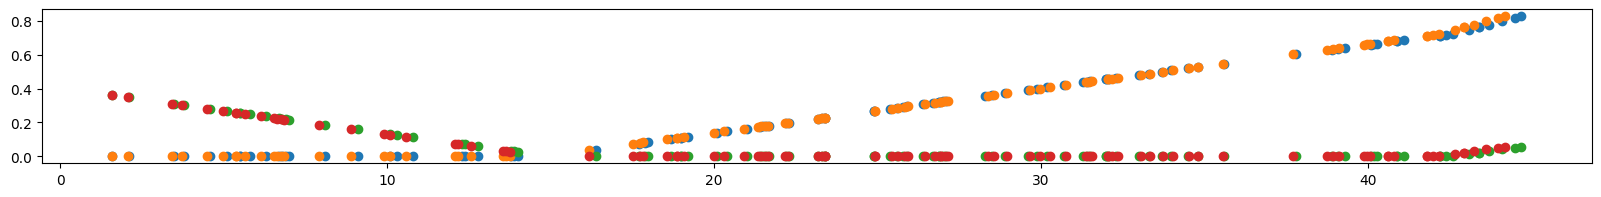

In [383]:
fig = plt.figure(figsize = (20,2))
ax = plt.axes()
for i in range(len(channel_id)):
    ax.scatter(y_test_2, x_test_2[:,i])
    ax.scatter(model2.predict(x_test_2), x_test_2[:,i])


# Experiment with 2 channels
#### MLP with 2 or more hidden layers have about the same loss.
#### A model with 2 hidden layers size of 32 and 16 and small batch size of 8 converage around 150 to 200 epochs only for pair of channels (1,7)
#### The model preform better with channel 1 and channel that is perpendicular to channel 1 through the origin. It converges faster than the channel that is on the same axis.
#### Again, The relu activation outpreform sigmoid activation.
#### Larger batch size seem to preform worse.
#### 2 Channels give smaller MAE score than 1 channel


# Experiment with 4 Channels

In [29]:
# Train/Test with 2 channel
channel_id = [1,13,16,2] 
x_train_4 = x_train[:, channel_id]
y_train_4 = y_train
x_test_4 = x_test[:, channel_id]
y_test_4 = y_test

x_train_4.shape

(400, 4)

In [30]:
x_train_4 = x_train_4 - x_train_4[:,[0]]
x_test_4 = x_test_4 - x_test_4[:,[0]]
x_train_4[:10]

array([[0.        , 0.03823813, 0.67157507, 0.48174977],
       [0.        , 0.06654223, 0.68696594, 0.4956883 ],
       [0.        , 0.31328723, 0.77365893, 0.5834262 ],
       [0.        , 0.19489796, 0.7432532 , 0.54928887],
       [0.        , 0.30774367, 0.7727541 , 0.58219683],
       [0.        , 0.45733282, 0.7749489 , 0.5995634 ],
       [0.        , 0.14821729, 0.72540957, 0.53166395],
       [0.        , 0.11426698, 0.7105215 , 0.5174865 ],
       [0.        , 0.2740049 , 0.7660913 , 0.5738926 ],
       [0.        , 0.03084244, 0.66738117, 0.477985  ]], dtype=float32)

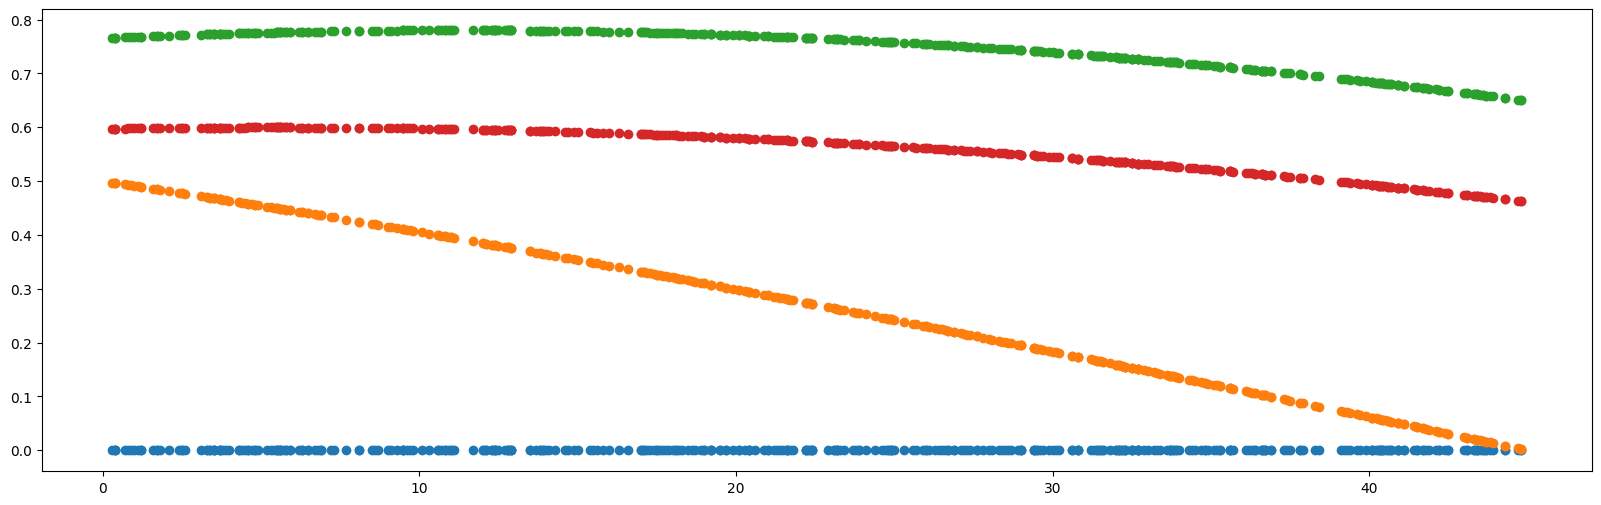

In [31]:
fig = plt.figure(figsize = (20,6))
ax = plt.axes()
for i in range(len(channel_id)):
    ax.scatter(y_train_4, x_train_4[:,i])

In [32]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Input(x_train_4[0].shape),
    #tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=1, activation = 'linear')
])
model4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
model4.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [34]:
losses = model4.fit(x_train_4, y_train_4,
                   batch_size=8,
                   epochs=200)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 737.1627 - mae: 23.9067    
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 660.5941 - mae: 22.1730 
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 627.9747 - mae: 21.5890 
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 553.4167 - mae: 19.5736
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 485.6727 - mae: 18.2239
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 366.9987 - mae: 15.5307 
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 288.6644 - mae: 14.2143 
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 285.8769 - mae: 14.6736
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 223.3498 - mae: 12.7385 
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 192.8402 - mae: 11.9201 
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 226.5549 - mae: 13.0687
Epoch 12/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 214.0

In [35]:
model4.predict(x_test_4), y_test_4

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


(array([[ 8.948809 ],
        [ 2.4543967],
        [ 6.721031 ],
        [31.298033 ],
        [14.878796 ],
        [31.196684 ],
        [23.264769 ],
        [ 9.534571 ],
        [22.959679 ],
        [29.369812 ],
        [29.57301  ],
        [11.993681 ],
        [23.061367 ],
        [35.134136 ],
        [ 2.0817192],
        [21.638628 ],
        [26.928776 ],
        [ 4.713701 ],
        [35.836796 ],
        [13.5815735],
        [ 6.4326377],
        [19.914425 ],
        [44.025127 ],
        [44.60425  ],
        [44.411434 ],
        [ 2.2679145],
        [41.100765 ],
        [14.17955  ],
        [ 0.7446937],
        [24.587492 ],
        [15.078877 ],
        [40.41208  ],
        [ 1.6174943],
        [33.72473  ],
        [28.861645 ],
        [27.74289  ],
        [ 3.015541 ],
        [ 8.656615 ],
        [37.13767  ],
        [10.122116 ],
        [34.430084 ],
        [27.030556 ],
        [41.78717  ],
        [43.249863 ],
        [30.993927 ],
        [1

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


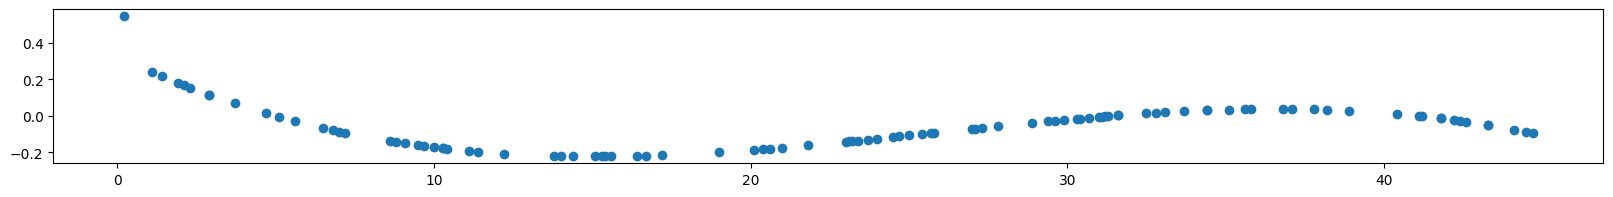

In [36]:
fig = plt.figure(figsize = (20,2))
ax = plt.axes()
#for i in range(len(channel_id)):
ax.scatter(y_test_4, model4.predict(x_test_4).flatten() - y_test_4)
    #ax.scatter(y_test_4, x_test_4[:,i])
    #ax.scatter(model4.predict(x_test_4), x_test_4[:,i])



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


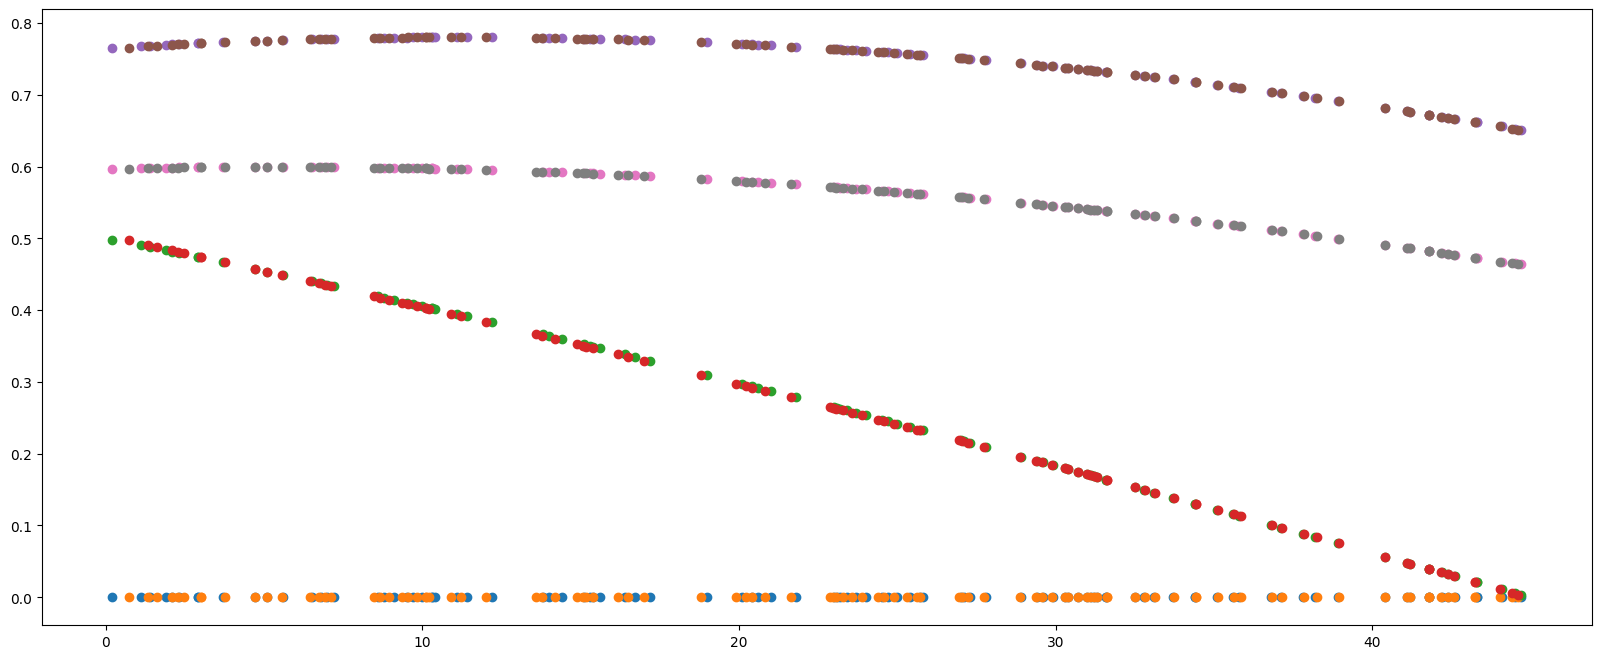

In [37]:
fig = plt.figure(figsize = (20,8))
ax = plt.axes()
for i in range(len(channel_id)):
    ax.scatter(y_test_4, x_test_4[:,i])
    ax.scatter(model4.predict(x_test_4), x_test_4[:,i])



In [424]:
model4.predict(x_test_4).flatten() - y_test_4

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


array([-0.07916908,  0.04246902,  0.04635391,  0.01985512, -0.06350784,
       -0.06386681,  0.04087372,  0.03911171,  0.00452957, -0.08978806,
        0.05349555, -0.06362076, -0.17527695, -0.03437424, -0.05744705,
        0.12552605,  0.04577255, -0.06071625,  0.03829651,  0.01828232,
       -0.11944809,  0.0139801 ,  0.1195652 ,  0.02531815, -0.03322563,
        0.0643856 , -0.03207703,  0.01193848,  0.00452957,  0.02443466,
        0.00123444, -0.03701553,  0.0446785 ,  0.03672028,  0.13156319,
        0.0226429 , -0.07330589, -0.06103897, -0.04989204, -0.0355114 ,
       -0.06854248,  0.04634781, -0.17062912, -0.07083549, -0.09330673,
        0.01498184, -0.18473282, -0.02629395, -0.02092056, -0.08280888,
        0.0314827 , -0.12741623,  0.04580765, -0.02284317,  0.04632187,
       -0.06103897, -0.06559906, -0.02081223,  0.04577255,  0.04509277,
       -0.01222014, -0.00945511, -0.05910606, -0.04003906, -0.17527695,
        0.04460106, -0.07002258, -0.09688644, -0.05158844,  0.04

# Test

In [442]:
# Train/Test with 2 channel
channel_id = [1,7,18,13] 
x_train_4 = x_train[:, channel_id]
y_train_4 = y_train
x_test_4 = x_test[:, channel_id]
y_test_4 = y_test

x_train_4.shape

(400, 4)

In [443]:
x_train_4 = x_train_4 - x_train_4[:,[0]]
x_test_4 = x_test_4 - x_test_4[:,[0]]
x_train_4[:10]

array([[ 0.        , -0.45757538, -0.18659484,  0.9489191 ],
       [ 0.        ,  0.29947054,  1.2322276 ,  2.7941568 ],
       [ 0.        ,  0.11387397,  0.89977866,  2.3891208 ],
       [ 0.        , -0.4989197 , -0.26904744,  0.83286417],
       [ 0.        , -0.5271199 , -0.3256157 ,  0.7526945 ],
       [ 0.        ,  0.11116529,  0.8948527 ,  2.3829815 ],
       [ 0.        , -0.5804088 , -0.43325925,  0.5988972 ],
       [ 0.        , -0.5398746 , -0.35129052,  0.7161599 ],
       [ 0.        , -0.04623609,  0.6049841 ,  2.0151    ],
       [ 0.        , -0.26223192,  0.19562808,  1.4746412 ]],
      dtype=float32)

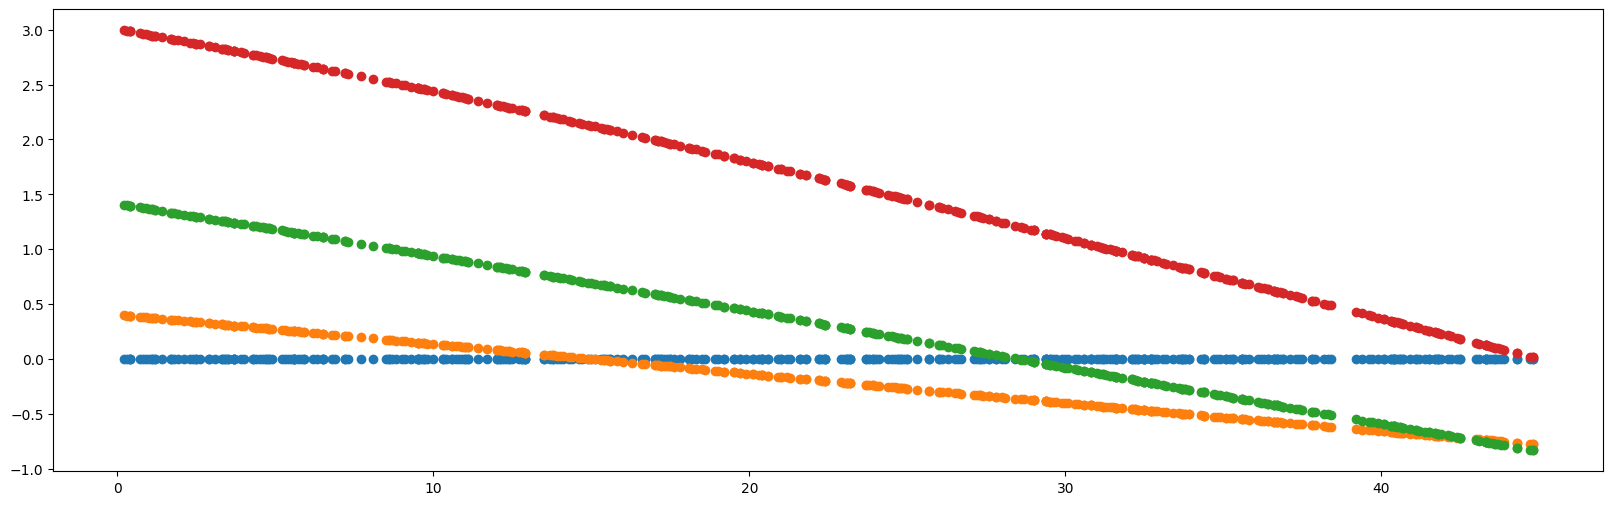

In [444]:
fig = plt.figure(figsize = (20,6))
ax = plt.axes()
for i in range(len(channel_id)):
    ax.scatter(y_train_4, x_train_4[:,i])

In [445]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Input(x_train_4[0].shape),
    #tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=1, activation = 'linear')
])
model4.summary()

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_221 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

In [446]:
model4.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [447]:
losses = model4.fit(x_train_4, y_train_4,
                   batch_size=8,
                   epochs=200)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 694.0431 - mae: 22.8801   
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 608.7482 - mae: 20.5230 
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 601.1650 - mae: 20.2160
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 473.8510 - mae: 17.8271
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 338.5877 - mae: 15.1838
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 245.4361 - mae: 13.2992
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171.0070 - mae: 11.1756 
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 95.3570 - mae: 8.2710
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 53.1730 - mae: 6.0886
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 20.3090 - mae: 3.5923
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 6.2172 - mae: 1.7740
Epoch 12/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 2.3411 - ma

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


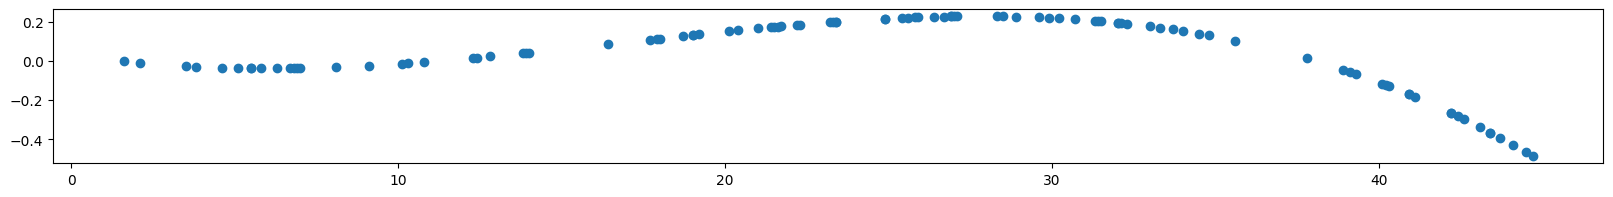

In [448]:
fig = plt.figure(figsize = (20,2))
ax = plt.axes()
#for i in range(len(channel_id)):
ax.scatter(y_test_4, model4.predict(x_test_4).flatten() - y_test_4)
    #ax.scatter(y_test_4, x_test_4[:,i])
    #ax.scatter(model4.predict(x_test_4), x_test_4[:,i])



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


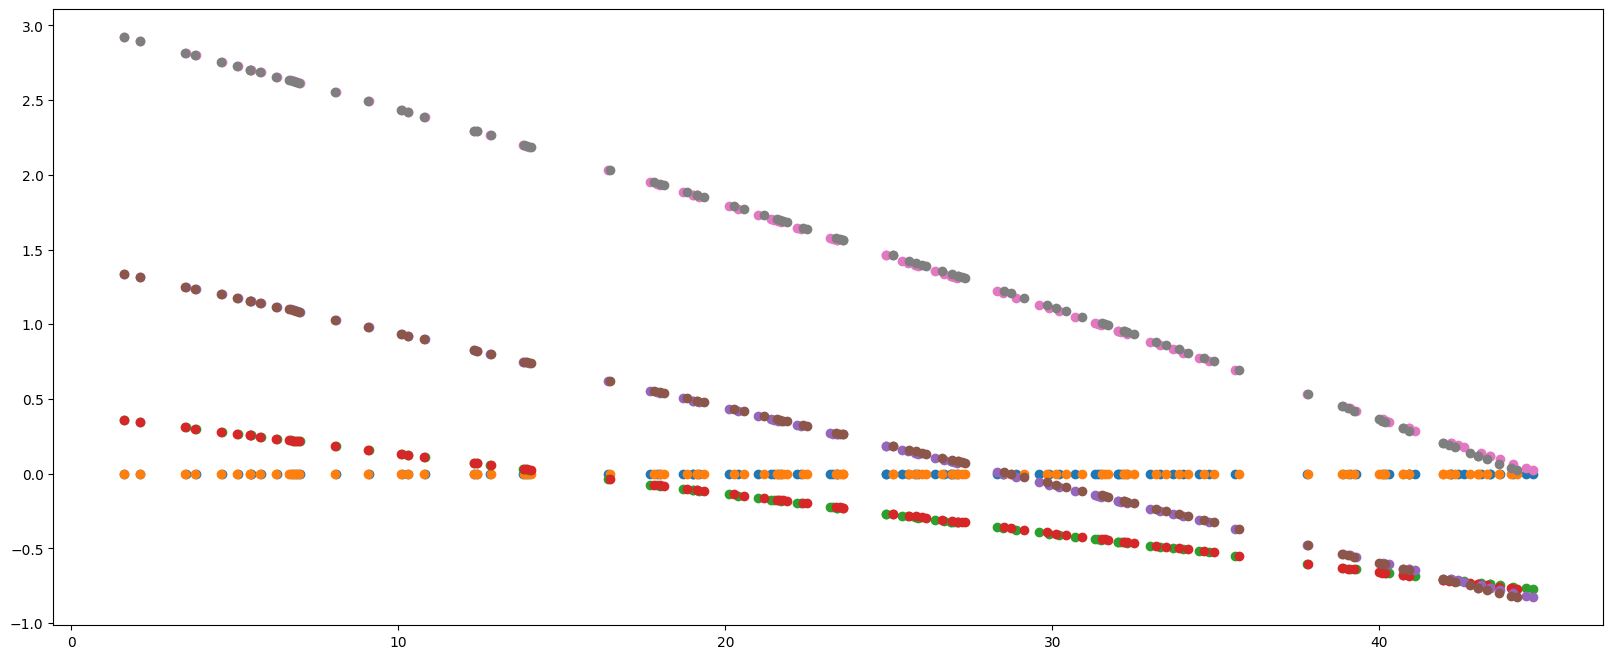

In [449]:
fig = plt.figure(figsize = (20,8))
ax = plt.axes()
for i in range(len(channel_id)):
    ax.scatter(y_test_4, x_test_4[:,i])
    ax.scatter(model4.predict(x_test_4), x_test_4[:,i])



In [424]:
model4.predict(x_test_4).flatten() - y_test_4

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


array([-0.07916908,  0.04246902,  0.04635391,  0.01985512, -0.06350784,
       -0.06386681,  0.04087372,  0.03911171,  0.00452957, -0.08978806,
        0.05349555, -0.06362076, -0.17527695, -0.03437424, -0.05744705,
        0.12552605,  0.04577255, -0.06071625,  0.03829651,  0.01828232,
       -0.11944809,  0.0139801 ,  0.1195652 ,  0.02531815, -0.03322563,
        0.0643856 , -0.03207703,  0.01193848,  0.00452957,  0.02443466,
        0.00123444, -0.03701553,  0.0446785 ,  0.03672028,  0.13156319,
        0.0226429 , -0.07330589, -0.06103897, -0.04989204, -0.0355114 ,
       -0.06854248,  0.04634781, -0.17062912, -0.07083549, -0.09330673,
        0.01498184, -0.18473282, -0.02629395, -0.02092056, -0.08280888,
        0.0314827 , -0.12741623,  0.04580765, -0.02284317,  0.04632187,
       -0.06103897, -0.06559906, -0.02081223,  0.04577255,  0.04509277,
       -0.01222014, -0.00945511, -0.05910606, -0.04003906, -0.17527695,
        0.04460106, -0.07002258, -0.09688644, -0.05158844,  0.04